In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os

sns.set_context('talk')

In [2]:
input_train_path = os.path.join(
    '..',
    'dataset',
    'feature-engineering',
    'iteration-1.csv'
)

df_train = pd.read_csv(input_train_path)
df_train.head()

,sessionNo,startHour,startWeekday,duration,cCount,cMinPrice,cMaxPrice,cSumPrice,bCount,bMinPrice,...,availability_mainly_not_orderable,availability_mainly_orderable,address_-99,address_1,address_2,time_of_day_afternoon,time_of_day_early_morning,time_of_day_evening,onlineStatus_-99,onlineStatus_0
0,1,6.0,5.0,0.000,1.0,59.99,59.99,59.99,1.0,59.99,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1,6.0,5.0,11.940,1.0,59.99,59.99,59.99,1.0,59.99,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,6.0,5.0,39.887,1.0,59.99,59.99,59.99,1.0,59.99,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2,6.0,5.0,0.000,0.0,-99.00,-99.00,-99.00,0.0,-99.00,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2,6.0,5.0,15.633,0.0,-99.00,-99.00,-99.00,0.0,-99.00,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
df_train.iloc[0]

sessionNo                                         1
startHour                                       6.0
startWeekday                                    5.0
duration                                        0.0
cCount                                          1.0
cMinPrice                                     59.99
cMaxPrice                                     59.99
cSumPrice                                     59.99
bCount                                          1.0
bMinPrice                                     59.99
bMaxPrice                                     59.99
bSumPrice                                     59.99
bStep                                         -99.0
onlineStatus                                    -99
availability                                    -99
customerNo                                      1.0
maxVal                                        600.0
customerScore                                  70.0
accountLifetime                                21.0
payments    

# Prepare training and test set

In [4]:
## remove redundant features - we've done one hot encoding
df_train.drop(
    labels=["availability", "address", "time_of_day", "onlineStatus"], 
    axis=1,
    inplace=True
)

In [5]:
categorical_feature_list = [
    'availability_-99', 'availability_completely_not_determinable',
    'availability_completely_not_orderable','availability_completely_orderable',
    'availability_mainly_not_determinable','availability_mainly_not_orderable', 
    'availability_mainly_orderable',
    'address_-99', 'address_1', 'address_2', 
    'time_of_day_afternoon','time_of_day_early_morning', 'time_of_day_evening', 
    'onlineStatus_-99','onlineStatus_0'
]

for col in categorical_feature_list:
    df_train[col] = df_train[col].astype(int)

In [6]:
## train test split (using original data, without handling imbalanced class distribution)
from sklearn.model_selection import train_test_split

TEST_PROPORTION = 0.3
RND = 121
target_class = 'order'
features = df_train.columns[(df_train.columns != target_class)]

X_train, X_test, y_train, y_test = train_test_split(
    df_train[features], 
    df_train[target_class],
    test_size=TEST_PROPORTION,
    random_state=RND
)

X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)

X_test.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

In [7]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(300309, 35) (300309,)
(128704, 35) (128704,)


In [8]:
from sklearn.metrics import accuracy_score, classification_report, f1_score
from sklearn.metrics import roc_auc_score

def evaluate_performance(y_true, y_pred, print_results = True):
    accuracy = accuracy_score(y_true, y_pred)
    f_score = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_pred)
    
    if print_results:
        print(f"Accuracy : {accuracy:.3%}")
        print(f"F1-score : {f_score:.3%}")
        print(f"AUC: {auc:.3f}")
        print(classification_report(y_true, y_pred))
        
    return accuracy, f_score, auc

In [9]:
from sklearn.model_selection import KFold

def kfold_cv(clf, X_train, y_train, k = 10):
    kfold = KFold(random_state = RND, shuffle = True, n_splits = k)
    
    cv_accuracy = np.zeros(shape=k)
    cv_f1 = np.zeros(shape=k)
    cv_auc = np.zeros(shape=k)
    
    i = 0
    for train_index, val_index in kfold.split(X_train):
        X_tr = X_train.loc[train_index]
        y_tr = y_train.loc[train_index]
        X_val = X_train.loc[val_index]
        y_val = y_train.loc[val_index]
        
        clf.fit(X_tr, y_tr)
        y_pred = clf.predict(X_val)
        accuracy, f_score, auc = evaluate_performance(y_val, y_pred, print_results = False)
        print(f"Iteration {i+1}: Accuracy={accuracy:.3%} | F1-score={f_score:.3%} | AUC={auc:.3f}")
        
        cv_accuracy[i] = accuracy
        cv_f1[i] = f_score
        cv_auc[i] = auc
        
        i += 1
    
    print("Cross-validation results")
    print("========================")
    print(f"Accuracy: {np.mean(cv_accuracy):.3%} +- {np.std(cv_accuracy):.3%}")
    print(f"F1-score: {np.mean(cv_f1):.3%} +- {np.std(cv_f1):.3%}")
    print(f"AUC: {np.mean(cv_auc):.3f} +- {np.std(cv_auc):.3f}")

# Model Training and Evaluation

## Baseline: Logistic Regression without fine-tuning

In [10]:
from sklearn.linear_model import LogisticRegression

model_logres = LogisticRegression(random_state=RND, max_iter=200, solver='saga', penalty='elasticnet', l1_ratio=0.2)

## Perform k-fold cross-validation
KFOLD_ITER = 5
kfold_cv(model_logres, X_train, y_train, k=KFOLD_ITER)

## Train with the whole training set
model_logres.fit(X_train, y_train)

/home/elvyna/miniconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Iteration 1: Accuracy=71.869% | F1-score=80.176% | AUC=0.652


/home/elvyna/miniconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Iteration 2: Accuracy=71.626% | F1-score=80.029% | AUC=0.649


/home/elvyna/miniconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Iteration 3: Accuracy=71.766% | F1-score=80.151% | AUC=0.650


/home/elvyna/miniconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Iteration 4: Accuracy=71.388% | F1-score=79.866% | AUC=0.646


/home/elvyna/miniconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Iteration 5: Accuracy=71.702% | F1-score=80.108% | AUC=0.649
Cross-validation results
Accuracy: 71.670% +- 0.162%
F1-score: 80.066% +- 0.112%
AUC: 0.649 +- 0.002


/home/elvyna/miniconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression(l1_ratio=0.2, max_iter=200, penalty='elasticnet',
                   random_state=121, solver='saga')

In [11]:
y_pred = model_logres.predict(X_test)
accuracy, f_score, auc = evaluate_performance(y_test, y_pred)

Accuracy : 71.481%
F1-score : 79.903%
AUC: 0.647
              precision    recall  f1-score   support

           0       0.58      0.45      0.51     41947
           1       0.76      0.84      0.80     86757

    accuracy                           0.71    128704
   macro avg       0.67      0.65      0.65    128704
weighted avg       0.70      0.71      0.70    128704



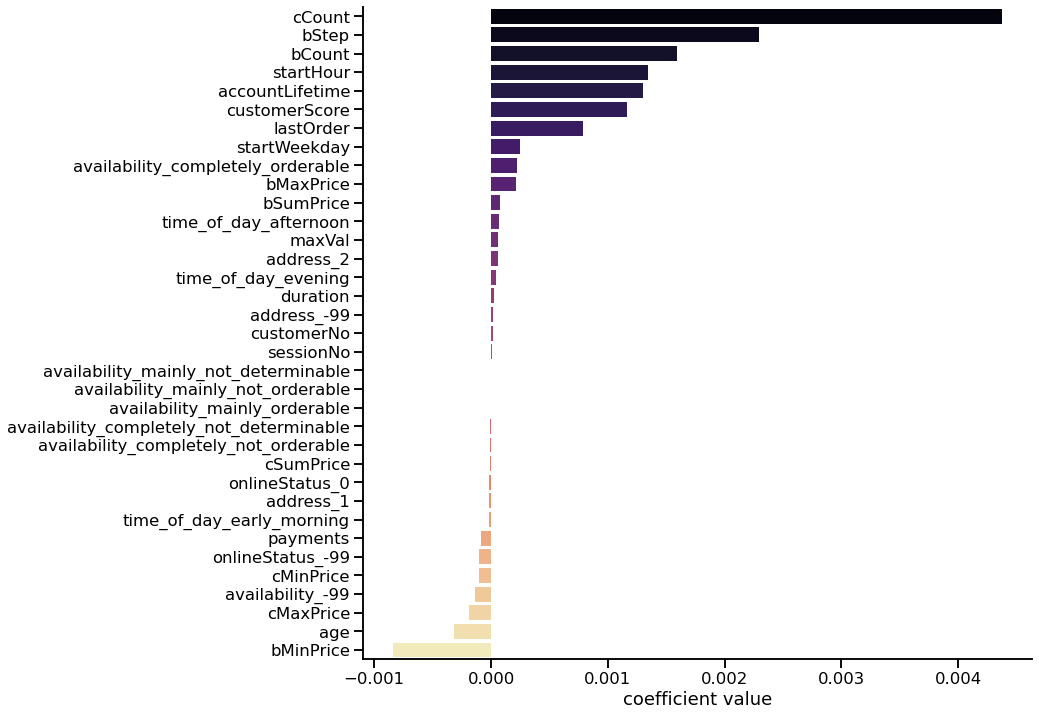

In [12]:
logres_coef = pd.DataFrame(
    data = {
        'feature_name': X_train.columns,
        'coef': model_logres.coef_[0]
    }
).sort_values(by='coef', ascending=False)
logres_coef['coef_abs'] = np.abs(logres_coef['coef'])


f, ax = plt.subplots(figsize=(12, 12))
sns.barplot(
    data=logres_coef,
    y='feature_name',
    x='coef',
    orient='h',
    palette='magma',
    ax=ax
);

plt.xlabel('coefficient value')
plt.ylabel('')
sns.despine();

# Random Forest

In [13]:
from sklearn.ensemble import RandomForestClassifier

model_rf = RandomForestClassifier(random_state=RND)

## Perform k-fold cross-validation
KFOLD_ITER = 5
kfold_cv(model_rf, X_train, y_train, k=KFOLD_ITER)

## Train with the whole training set
model_rf.fit(X_train, y_train)

Iteration 1: Accuracy=90.423% | F1-score=93.024% | AUC=0.881
Iteration 2: Accuracy=90.535% | F1-score=93.163% | AUC=0.881
Iteration 3: Accuracy=90.526% | F1-score=93.142% | AUC=0.881
Iteration 4: Accuracy=90.506% | F1-score=93.126% | AUC=0.880
Iteration 5: Accuracy=90.701% | F1-score=93.264% | AUC=0.883
Cross-validation results
Accuracy: 90.538% +- 0.090%
F1-score: 93.144% +- 0.077%
AUC: 0.881 +- 0.001


RandomForestClassifier(random_state=121)

In [14]:
y_pred = model_rf.predict(X_test)
accuracy, f_score, auc = evaluate_performance(y_test, y_pred)

Accuracy : 91.432%
F1-score : 93.742%
AUC: 0.894
              precision    recall  f1-score   support

           0       0.89      0.84      0.86     41947
           1       0.92      0.95      0.94     86757

    accuracy                           0.91    128704
   macro avg       0.91      0.89      0.90    128704
weighted avg       0.91      0.91      0.91    128704



In [15]:
model_rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 121,
 'verbose': 0,
 'warm_start': False}

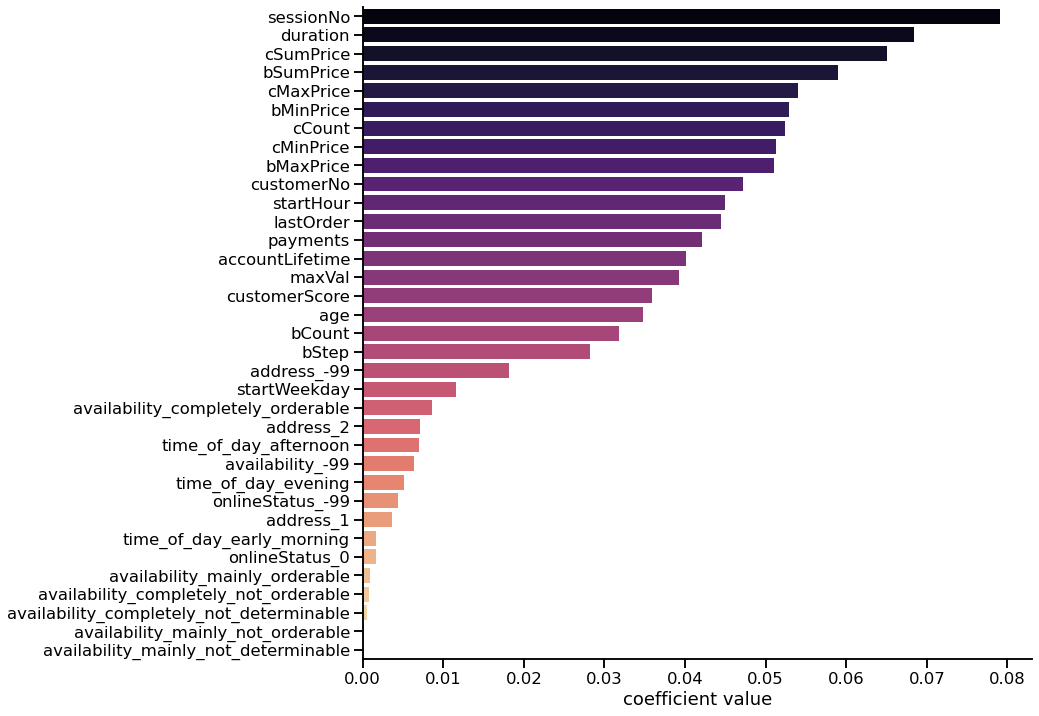

In [16]:
rf_coef = pd.DataFrame(
    data = {
        'feature_name': X_train.columns,
        'coef': model_rf.feature_importances_
    }
).sort_values(by='coef', ascending=False)
rf_coef['coef_abs'] = np.abs(rf_coef['coef'])


f, ax = plt.subplots(figsize=(12, 12))
sns.barplot(
    data=rf_coef,
    y='feature_name',
    x='coef',
    orient='h',
    palette='magma',
    ax=ax
);

plt.xlabel('coefficient value')
plt.ylabel('')
sns.despine();

# LightGBM

In [17]:
import lightgbm as lgbm

model_lgbm = lgbm.LGBMClassifier(
    random_state=RND,
    objective='binary',
    learning_rate=0.2,
    subsample=0.7,
    subsample_freq=3,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=0.1,
)

## Perform k-fold cross-validation
KFOLD_ITER = 5
kfold_cv(model_lgbm, X_train, y_train, k=KFOLD_ITER)

## Train with the whole training set
model_lgbm.fit(X_train, y_train, categorical_feature=categorical_feature_list)

Iteration 1: Accuracy=78.847% | F1-score=85.149% | AUC=0.729
Iteration 2: Accuracy=79.216% | F1-score=85.437% | AUC=0.733
Iteration 3: Accuracy=79.328% | F1-score=85.488% | AUC=0.735
Iteration 4: Accuracy=78.892% | F1-score=85.210% | AUC=0.729
Iteration 5: Accuracy=79.113% | F1-score=85.366% | AUC=0.732
Cross-validation results
Accuracy: 79.079% +- 0.185%
F1-score: 85.330% +- 0.130%
AUC: 0.732 +- 0.003


/home/elvyna/miniconda3/envs/py37/lib/python3.7/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


LGBMClassifier(colsample_bytree=0.8, learning_rate=0.2, objective='binary',
               random_state=121, reg_alpha=0.1, reg_lambda=0.1, subsample=0.7,
               subsample_freq=3)

In [18]:
model_lgbm.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 0.8,
 'importance_type': 'split',
 'learning_rate': 0.2,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': 'binary',
 'random_state': 121,
 'reg_alpha': 0.1,
 'reg_lambda': 0.1,
 'silent': True,
 'subsample': 0.7,
 'subsample_for_bin': 200000,
 'subsample_freq': 3}

In [19]:
y_pred = model_lgbm.predict(X_test)
accuracy, f_score, auc = evaluate_performance(y_test, y_pred)

Accuracy : 79.029%
F1-score : 85.248%
AUC: 0.732
              precision    recall  f1-score   support

           0       0.73      0.57      0.64     41947
           1       0.81      0.90      0.85     86757

    accuracy                           0.79    128704
   macro avg       0.77      0.73      0.74    128704
weighted avg       0.78      0.79      0.78    128704



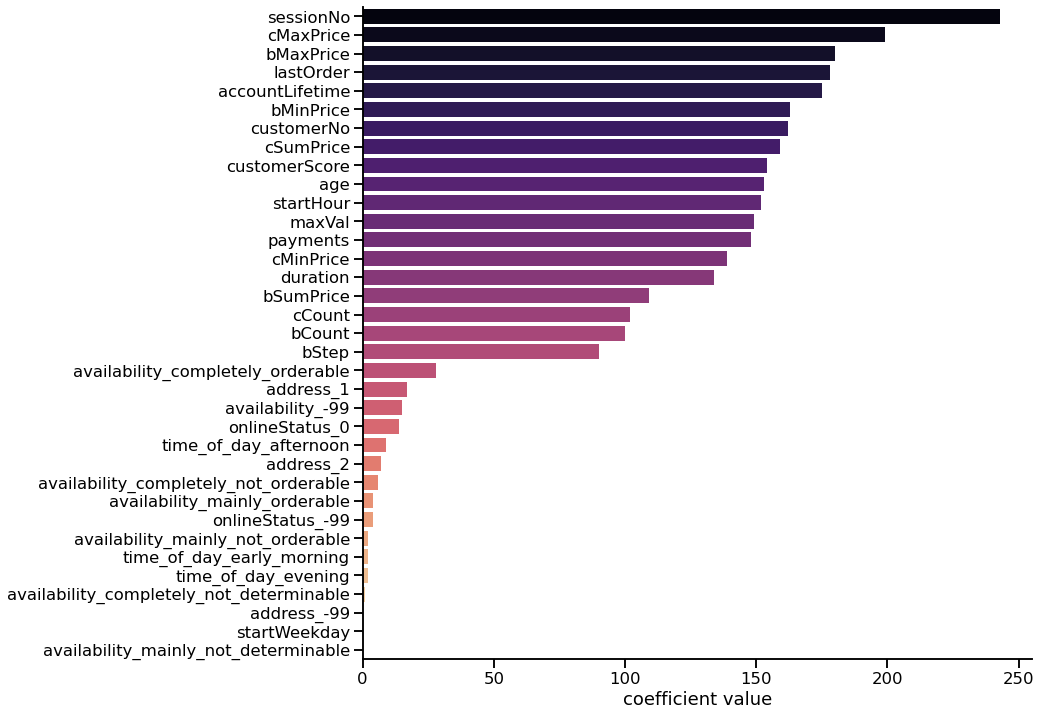

In [24]:
lgbm_coef = pd.DataFrame(
    data = {
        'feature_name': X_train.columns,
        'coef': model_lgbm.feature_importances_
    }
).sort_values(by='coef', ascending=False)
lgbm_coef['coef_abs'] = np.abs(lgbm_coef['coef'])


f, ax = plt.subplots(figsize=(12, 12))
sns.barplot(
    data=lgbm_coef,
    y='feature_name',
    x='coef',
    orient='h',
    palette='magma',
    ax=ax
);

plt.xlabel('coefficient value')
plt.ylabel('')
sns.despine();

# Catboost

In [20]:
from catboost import CatBoostClassifier

## https://catboost.ai/en/docs/concepts/parameter-tuning
model_catboost = CatBoostClassifier(
    iterations=100,
    learning_rate=0.2,
    max_depth=10,
    l2_leaf_reg=0.1,
    random_state=RND
)

## Perform k-fold cross-validation
KFOLD_ITER = 5
kfold_cv(model_catboost, X_train, y_train, k=KFOLD_ITER)

## Fit model
model_catboost.fit(X_train, y_train, cat_features=categorical_feature_list)
# # Get predicted classes
# preds_class = model_catboost.predict(eval_data)
# # Get predicted probabilities for each class
# preds_proba = model_catboost.predict_proba(eval_data)
# # Get predicted RawFormulaVal
# preds_raw = model_catboost.predict(eval_data, prediction_type='RawFormulaVal')

0:	learn: 0.6239267	total: 315ms	remaining: 31.2s
1:	learn: 0.5818308	total: 417ms	remaining: 20.4s
2:	learn: 0.5551344	total: 524ms	remaining: 16.9s
3:	learn: 0.5368604	total: 631ms	remaining: 15.1s
4:	learn: 0.5249728	total: 741ms	remaining: 14.1s
5:	learn: 0.5173683	total: 847ms	remaining: 13.3s
6:	learn: 0.5111557	total: 951ms	remaining: 12.6s
7:	learn: 0.5063165	total: 1.06s	remaining: 12.2s
8:	learn: 0.5026819	total: 1.17s	remaining: 11.8s
9:	learn: 0.4989795	total: 1.28s	remaining: 11.5s
10:	learn: 0.4960761	total: 1.39s	remaining: 11.2s
11:	learn: 0.4918483	total: 1.49s	remaining: 10.9s
12:	learn: 0.4889332	total: 1.59s	remaining: 10.7s
13:	learn: 0.4857498	total: 1.7s	remaining: 10.4s
14:	learn: 0.4833147	total: 1.81s	remaining: 10.3s
15:	learn: 0.4812005	total: 1.92s	remaining: 10.1s
16:	learn: 0.4788103	total: 2.02s	remaining: 9.87s
17:	learn: 0.4770865	total: 2.17s	remaining: 9.87s
18:	learn: 0.4749772	total: 2.27s	remaining: 9.68s
19:	learn: 0.4725107	total: 2.37s	remainin

In [21]:
model_catboost.get_params()

{'iterations': 100,
 'learning_rate': 0.2,
 'l2_leaf_reg': 0.1,
 'max_depth': 10,
 'random_state': 121}

In [23]:
y_pred = model_catboost.predict(X_test)
accuracy, f_score, auc = evaluate_performance(y_test, y_pred)

Accuracy : 83.070%
F1-score : 87.918%
AUC: 0.786
              precision    recall  f1-score   support

           0       0.79      0.66      0.72     41947
           1       0.85      0.91      0.88     86757

    accuracy                           0.83    128704
   macro avg       0.82      0.79      0.80    128704
weighted avg       0.83      0.83      0.83    128704



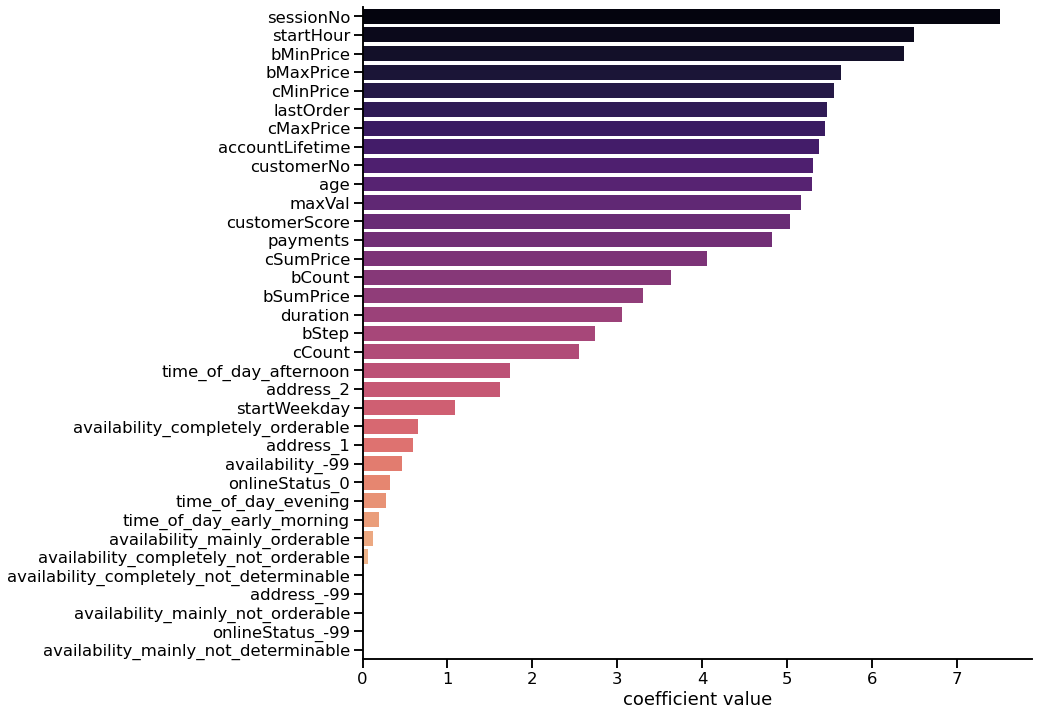

In [25]:
catboost_coef = pd.DataFrame(
    data = {
        'feature_name': X_train.columns,
        'coef': model_catboost.feature_importances_
    }
).sort_values(by='coef', ascending=False)
catboost_coef['coef_abs'] = np.abs(catboost_coef['coef'])


f, ax = plt.subplots(figsize=(12, 12))
sns.barplot(
    data=catboost_coef,
    y='feature_name',
    x='coef',
    orient='h',
    palette='magma',
    ax=ax
);

plt.xlabel('coefficient value')
plt.ylabel('')
sns.despine();